**Author**: *Konstantinos Tsintzas* (tsintzask6@gmail.com)

Project Description: [https://drive.google.com/file/d/19sBaIygmYRiXQgSNqLsjTgdDHiFnAEZP/view](https://drive.google.com/file/d/19sBaIygmYRiXQgSNqLsjTgdDHiFnAEZP/view)

Github Link:

# Import Libraries

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio
import io
import random
import time
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

from sklearn.metrics import accuracy_score,f1_score

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.backend import constant

# Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_location = '/content/drive/MyDrive/Colab Notebooks/data/rock-paper-scissors.zip'

data_filenames = {'rock':[],'paper':[],'scissors':[]}
raw_data = {'rock':[],'paper':[],'scissors':[]}

with zipfile.ZipFile(file_location) as zipped:
  names = zipped.namelist()

  for name in names:
    for move in data_filenames.keys():
      if move in name and 'rps-cv-images' not in name:
        data_filenames[move].append(name)

  for move in data_filenames.keys():
    for filename in data_filenames[move]:
      with zipped.open(filename) as img:
        raw_data[move].append(iio.imread(img))

# Make the Adversary

In [4]:
def adversary_transform(image):

  if random.random() < 0.5:
    image = np.flip(image,0)

  if random.random() < 0.5:
    image = np.flip(image,1)

  mean = 0
  std = 255*0.05
  noise = np.random.normal(mean, std, image.shape)
  image = image + noise
  image = np.clip(image, 0, 255).astype(np.uint8)

  return image

def adversary_pick(data,random_state=None):
  random.seed(random_state)

  chosen_move = random.choice(['rock','paper','scissors'])
  chosen_index = random.randint(0,len(data[chosen_move])-1)
  chosen_image = data[chosen_move][chosen_index]

  chosen_image = adversary_transform(chosen_image)

  return chosen_image,chosen_move

Let's test the adversary, just for fun.

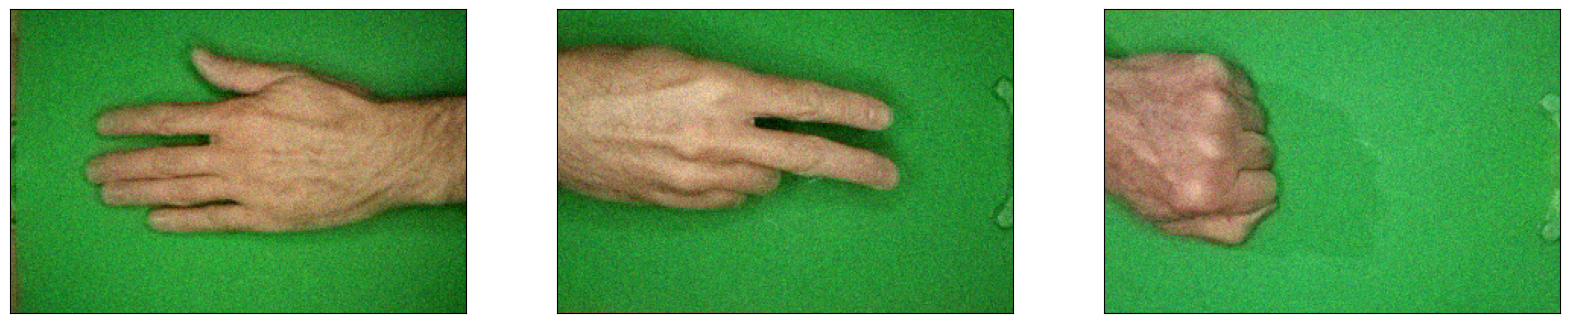

In [5]:
f, axarr = plt.subplots(1, 3, figsize=(20, 20))
for i in range(3):
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])

    image,move = adversary_pick(raw_data,random_state=i*6**i)

    axarr[i].imshow(image)

Neat! I picked a seed that makes a paper, scissors, and rock image.

In [34]:
adversary_data = {'rock':[],'paper':[],'scissors':[]}
for move in raw_data.keys():
  adversary_data[move] = raw_data[move]
  for i in range(len(adversary_data[move])):
    adversary_data[move][i] = adversary_transform(adversary_data[move][i])

# Generating Train and Test Sets

We're doing a 60-20-20 train-validation-test split. Because of the way our data is currently structured in a dictionary, it's also naturally stratified by class.

In [35]:
train = {'rock':[],'paper':[],'scissors':[]}
val = {'rock':[],'paper':[],'scissors':[]}
test = {'rock':[],'paper':[],'scissors':[]}
for move in adversary_data.keys():

  train[move],test[move] = train_test_split(adversary_data[move],test_size=0.2)
  train[move],val[move] = train_test_split(train[move],test_size=0.25)

We've got our dataset of noisy images now. Just need to put them into arrays and shuffle them for ease of use.

In [36]:
train_images = np.array(train['rock']+train['paper']+train['scissors'])
train_labels = np.array([0]*len(train['rock'])+[1]*len(train['paper'])+[2]*len(train['scissors']))

val_images = np.array(val['rock']+val['paper']+val['scissors'])
val_labels = np.array([0]*len(val['rock'])+[1]*len(val['paper'])+[2]*len(val['scissors']))

test_images = np.array(test['rock']+test['paper']+test['scissors'])
test_labels = np.array([0]*len(test['rock'])+[1]*len(test['paper'])+[2]*len(test['scissors']))

perm = np.random.permutation(len(train_images))
train_images = train_images[perm]
train_labels = train_labels[perm]

perm = np.random.permutation(len(val_images))
val_images = val_images[perm]
val_labels = val_labels[perm]

perm = np.random.permutation(len(test_images))
test_images = test_images[perm]
test_labels = test_labels[perm]

# Make the Model

So, for my model, I chose a convolutional neural network, since that stuff's great at processing images.

Model architecture has a few different layers. I built it based on the [tensorflow tutorial](https://www.tensorflow.org/tutorials/images/cnn) for convolutional neural networks, with a different-sized output layer.  
I also tried various tweaks to the architecture, and the following is what worked best in terms or architecture and training epochs.

In [89]:
model = models.Sequential()

model.add(layers.Conv2D(32, (10, 15), activation='relu', input_shape=(200, 300, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3)) # 3 output neurons correspond to 3 classes

model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [90]:
n_epochs = 10

checkpoint_path='rps_model.ckpt'

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=0)

history = model.fit(train_images, train_labels, epochs=n_epochs, validation_data=(val_images, val_labels), callbacks=[cp_callback])

Epoch 1/10
41/41 [==============================] - 6s 106ms/step - loss: 146.9007 - accuracy: 0.4561 - val_loss: 0.7403 - val_accuracy: 0.7306
Epoch 2/10
41/41 [==============================] - 4s 96ms/step - loss: 0.4096 - accuracy: 0.8406 - val_loss: 0.2835 - val_accuracy: 0.8950
Epoch 3/10
41/41 [==============================] - 4s 95ms/step - loss: 0.0881 - accuracy: 0.9725 - val_loss: 0.2629 - val_accuracy: 0.9087
Epoch 4/10
41/41 [==============================] - 4s 95ms/step - loss: 0.0145 - accuracy: 0.9985 - val_loss: 0.2547 - val_accuracy: 0.9315
Epoch 5/10
41/41 [==============================] - 4s 91ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2666 - val_accuracy: 0.9315
Epoch 6/10
41/41 [==============================] - 4s 89ms/step - loss: 7.4677e-04 - accuracy: 1.0000 - val_loss: 0.2826 - val_accuracy: 0.9361
Epoch 7/10
41/41 [==============================] - 4s 89ms/step - loss: 4.2229e-04 - accuracy: 1.0000 - val_loss: 0.2888 - val_accuracy: 0.9384
Ep

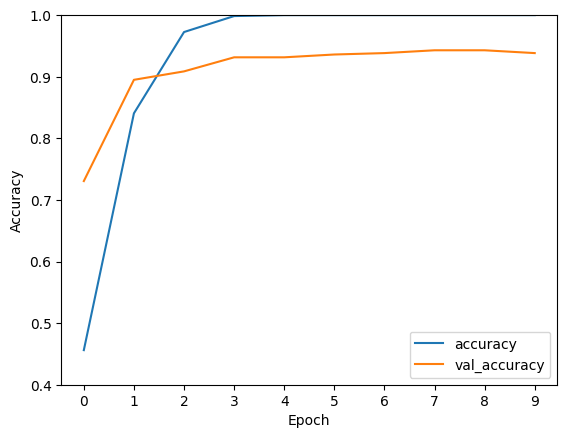

In [93]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.xticks(range(n_epochs))
plt.ylabel('Accuracy')
plt.ylim([0.4, 1])
plt.legend(loc='lower right')
plt.show()

In [129]:
print(f"Accuracy on the test set: {accuracy_score(test_labels,np.argmax(model.predict(test_images,verbose=0),axis=1))}")

Accuracy on the test set: 0.9271070615034168


Pretty good accuracy on the test set, too.
I'm saving this model's weights to use for the future.

In [159]:
print(f"F1 on the test set: {f1_score(test_labels,np.argmax(model.predict(test_images,verbose=0),axis=1),average='micro')}")

F1 on the test set: 0.9271070615034168


The F1 score is also high, as expected from balanced classes.

# The Fun Part

Now that I've got my model all figured out, I'll build an environment for the Rock-Paper-Scissors game.

In [135]:
model = models.Sequential()
model.add(layers.Conv2D(32, (10, 15), activation='relu', input_shape=(200, 300, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3))
status = model.load_weights('/content/drive/MyDrive/DWS Masters Program Projects/Machine Learning Final Project/rps_model.ckpt')

def prediction(images):
  return np.argmax(model.predict(images,verbose=0),axis=1)

def pick_move(prediction):
  rps = ["I think you played rock, so I'm playing paper ✋","I think you played paper, so I'm playing scissors ✌️","I think you played scissors, so I'm playing rock ✊"]
  print(f"\n{rps[prediction]}\n")

In [153]:
def main():
  print(f"Rock, Paper, Scissors ✊✋✌️\n(but the computer is cheating)\n")

  exited = False
  while not exited:

    user_input = "none"
    while user_input.lower() not in ["1","2","3","4","one","two","three","four"]:
      user_input = input(f"Choose an option by typing the number:\n1. Pick a move from rock, paper, scissors\n2. Upload a 200x300 png image of your move\n3. Play a random move\n4. Exit\n\n")
      plt.close()

    if user_input.lower() in ["1","one"]:
      chosen_move = "none"
      while chosen_move.lower() not in ["rock","paper","scissors"]:
        chosen_move = input(f"Type rock, paper, or scissors!\n\n")
        if chosen_move.lower() == "rock":
          pick_move(0)
        elif chosen_move.lower() == "paper":
          pick_move(1)
        elif chosen_move.lower() == "scissors":
          pick_move(2)

    elif user_input.lower() in ["2","two"]:
      uploaded = files.upload()
      for file_name in uploaded.keys():
        image = iio.imread(io.BytesIO(uploaded[file_name]))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image)
        plt.show()
        pick_move(prediction(np.asarray([image]))[0])

    elif user_input.lower() in ["3","three"]:
      image,move = adversary_pick(raw_data,random_state=None)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(image)
      plt.show()
      pick_move(prediction(np.asarray([image]))[0])

    elif user_input.lower() in ["4","four"]:
      print("Exiting game.")
      exited = True

    time.sleep(1)

  print("Exited successfully!")

And it's done. Simply run main() to make it work.

Rock, Paper, Scissors ✊✋✌️
(but the computer is cheating)

Choose an option by typing the number:
1. Pick a move from rock, paper, scissors
2. Upload a 200x300 png image of your move
3. Play a random move
4. Exit

2


Saving IMG_20240127_002352.png to IMG_20240127_002352.png
Saving IMG_20240127_002358.png to IMG_20240127_002358.png
Saving IMG_20240127_002410.png to IMG_20240127_002410.png
Saving IMG_20240127_002413.png to IMG_20240127_002413.png
Saving IMG_20240127_002416.png to IMG_20240127_002416.png
Saving IMG_20240127_002419.png to IMG_20240127_002419.png


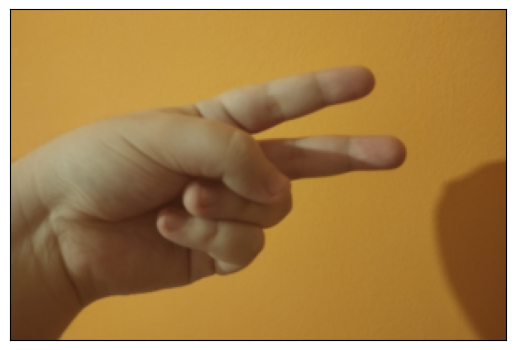


I think you played paper, so I'm playing scissors ✌️



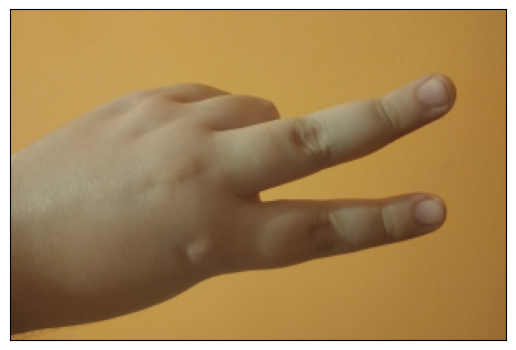


I think you played scissors, so I'm playing rock ✊



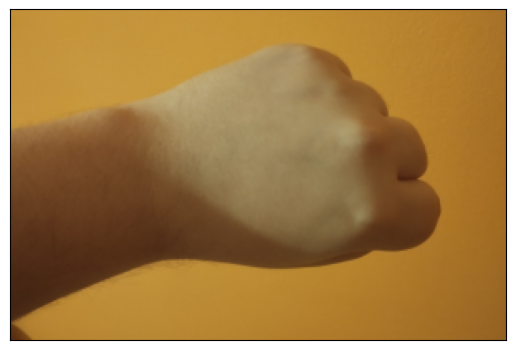


I think you played paper, so I'm playing scissors ✌️



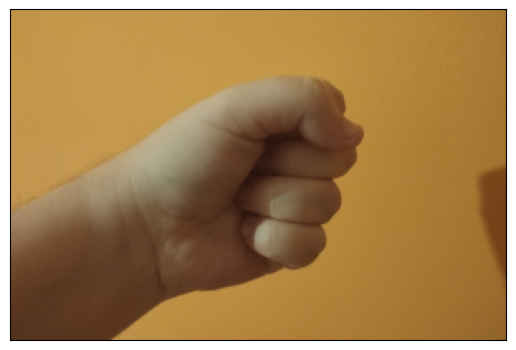


I think you played paper, so I'm playing scissors ✌️



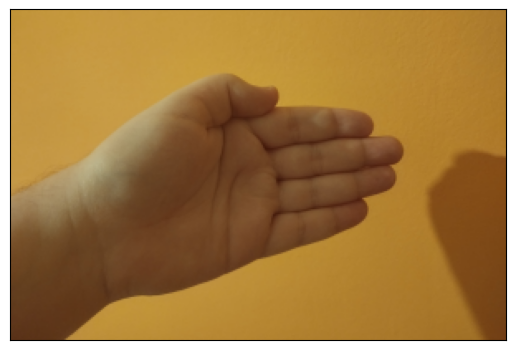


I think you played paper, so I'm playing scissors ✌️



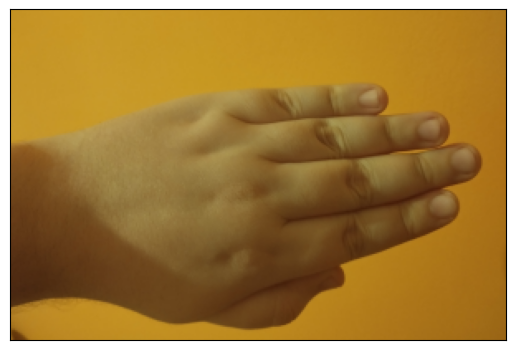


I think you played paper, so I'm playing scissors ✌️

Choose an option by typing the number:
1. Pick a move from rock, paper, scissors
2. Upload a 200x300 png image of your move
3. Play a random move
4. Exit

4
Exiting game.
Exited successfully!


In [154]:
main()

As we can see, the fact that every image in the training set had a green background has messed up our model a bit. Its guesses on images with harder-to-discern backgrounds are barely better than random - in 6 tests, it got 3 wins, 2 losses, and 1 draw.